Enter the input image filename:  dice.jpg
Enter the base output image filename (without prefix):  dice12.jpg
Enter the scaling factor (positive number):  2



CUDA output file: cuda_dice12.jpg
OpenMP output file: openmp_dice12.jpg
Sequential output file: sequential_dice12.jpg

Running CUDA version...
CUDA Execution Time: 0.3252 seconds
CUDA Peak Memory Usage: 115.58 MB
CUDA Average GPU Usage: 14.00 %
CUDA Per-Core Average CPU Usage: [31.67, 0.0, 24.43, 0.0, 0.0, 23.83, 46.8, 0.0, 0.0, 58.33, 0.0, 29.17, 34.93, 0.0, 35.7, 3.03, 4.77, 0.0, 33.33, 30.17]

Running OpenMP version...
OpenMP Execution Time: 1.3331 seconds
OpenMP Peak Memory Usage: 9.83 MB
OpenMP Per-Core Average CPU Usage: [83.0, 77.56, 85.3, 79.39, 78.1, 89.8, 91.84, 75.73, 86.73, 85.71, 90.26, 91.07, 95.57, 93.27, 83.33, 91.23, 86.11, 84.19, 88.27, 90.3]

Running Sequential version...
Sequential Execution Time: 12.4825 seconds
Sequential Peak Memory Usage: 9.22 MB
Sequential Per-Core Average CPU Usage: [5.1, 0.16, 3.98, 0.32, 0.73, 3.02, 28.29, 0.27, 33.66, 6.08, 48.68, 0.43, 31.82, 0.0, 14.28, 0.0, 1.11, 1.88, 4.53, 3.18]



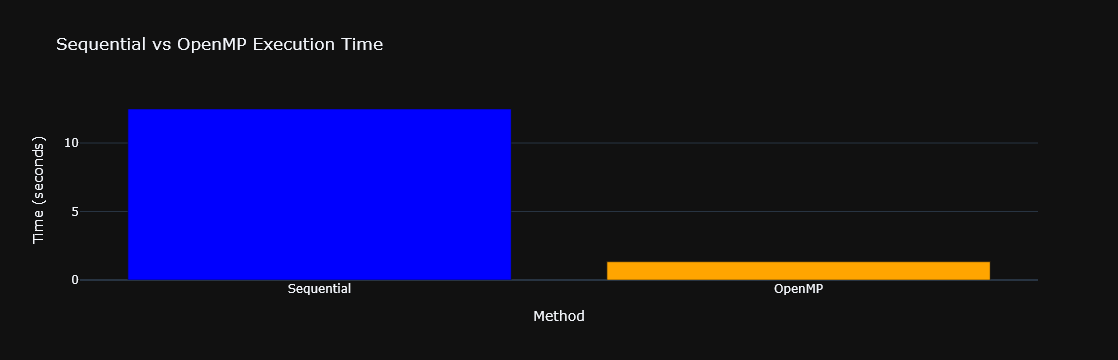

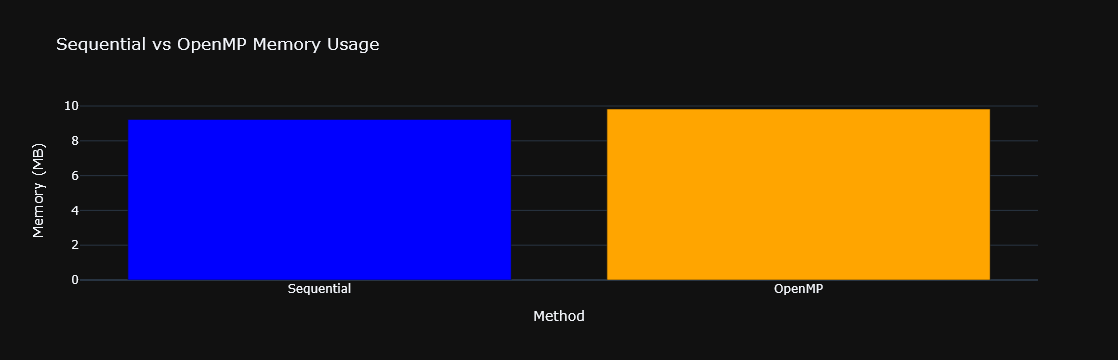

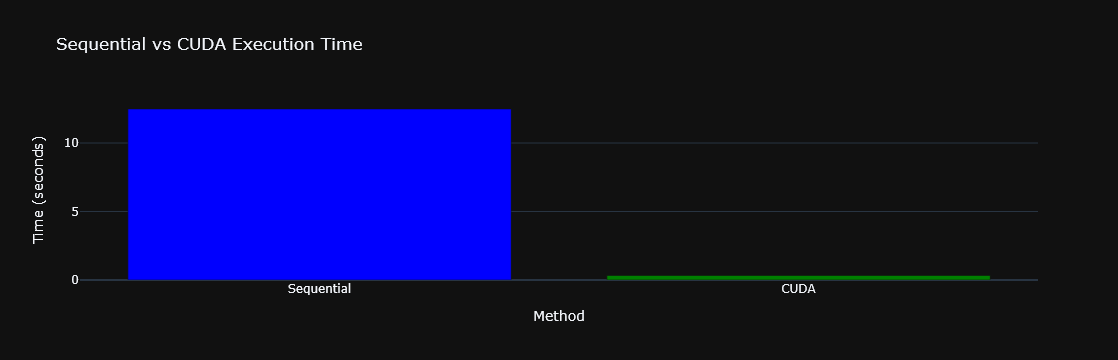

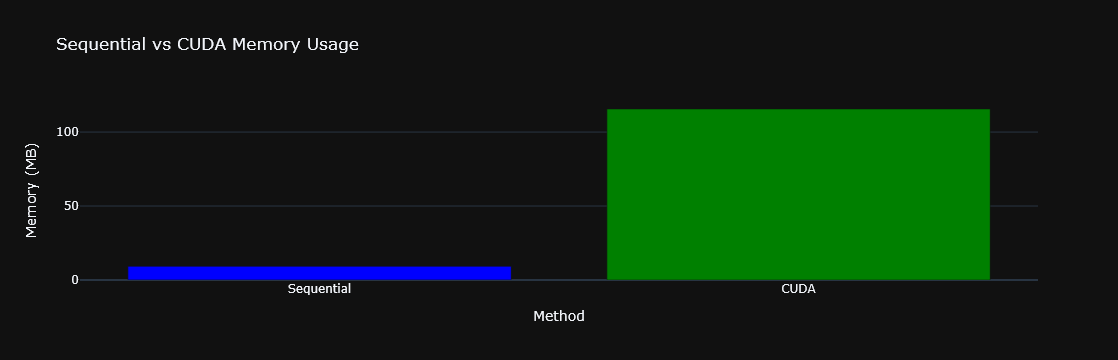

In [19]:
import subprocess
import time
import os
import psutil
import pynvml
import plotly.graph_objects as go

# Define paths to the executables
cuda_exe_path = r"C:\Users\user\Desktop\dspc\Assignment\Lanczos-Resampling\Lanczos Cuda\Lanczos\x64\Debug\Lanczos.exe"
openmp_exe_path = r"C:\Users\user\Desktop\dspc\Assignment\Lanczos-Resampling\OpenMP lanczos\x64\Debug\OpenMP larczos.exe"
sequential_exe_path = r"C:\Users\user\Desktop\dspc\Assignment\Lanczos-Resampling\Sequential lanczos\x64\Debug\Sequential lanczos.exe"

# Initialize GPU monitoring (only needed for CUDA)
def init_gpu_monitoring():
    try:
        pynvml.nvmlInit()
        return pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming single GPU system
    except pynvml.NVMLError as e:
        print(f"Error initializing GPU monitoring: {e}")
        return None

gpu_handle = init_gpu_monitoring()

def get_gpu_usage():
    """Returns GPU utilization percentage if available, otherwise None."""
    try:
        if gpu_handle:
            return pynvml.nvmlDeviceGetUtilizationRates(gpu_handle).gpu
    except pynvml.NVMLError:
        pass
    return None

def run_program_with_metrics(exe_path, input_image, output_image, scale_factor):
    """Runs the executable with provided arguments and tracks memory, CPU (per-core), and GPU usage."""
    if not os.path.exists(input_image):
        print(f"Error: Input image not found at full path: {os.path.abspath(input_image)}")
        return None, None, None, None, None, None, None

    max_memory = 0
    max_cpu = 0
    max_gpu = 0
    cpu_samples = []
    gpu_samples = []
    num_cores = psutil.cpu_count(logical=True)  # Get the number of logical cores
    per_core_max_usage = [0] * num_cores  # Initialize per-core max usage
    per_core_sum_usage = [0] * num_cores  # Initialize per-core sum for average usage
    num_samples = 0  # To track the number of CPU/GPU samples taken
    start_time = time.time()

    try:
        # Start the process
        process = subprocess.Popen(
            [exe_path, input_image, output_image, str(scale_factor)],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )

        # Use the process PID to track memory and CPU
        proc = psutil.Process(process.pid)

        # Monitor usage until the process completes
        while process.poll() is None:  # Check if the process is still running
            try:
                # Memory usage
                current_memory = proc.memory_info().rss / (1024 ** 2)  # Memory in MB
                max_memory = max(max_memory, current_memory)

                # CPU usage (per-core)
                current_per_core_usage = psutil.cpu_percent(interval=0.1, percpu=True)
                num_samples += 1
                for i, usage in enumerate(current_per_core_usage):
                    per_core_max_usage[i] = max(per_core_max_usage[i], usage)
                    per_core_sum_usage[i] += usage

                # GPU usage (if applicable)
                if "cuda" in exe_path.lower():  # Only track GPU usage for CUDA
                    current_gpu = get_gpu_usage()
                    if current_gpu is not None:
                        max_gpu = max(max_gpu, current_gpu)
                        gpu_samples.append(current_gpu)

            except psutil.NoSuchProcess:
                break  # The process might have exited

        # Compute average CPU usage per core
        per_core_avg_usage = [usage / num_samples for usage in per_core_sum_usage]

        # Compute average GPU usage (if applicable)
        avg_gpu = sum(gpu_samples) / len(gpu_samples) if gpu_samples else None

        # Collect the output and errors
        stdout, stderr = process.communicate()
        end_time = time.time()

        return end_time - start_time, max_memory, per_core_max_usage, per_core_avg_usage, max_gpu, avg_gpu, stdout, stderr

    except Exception as e:
        print(f"Error running {exe_path}: {e}")
        return None, None, None, None, None, None, None, None

def truncate_values(values, decimals=2):
    """Truncates a list of float values to a specified number of decimals."""
    return [round(value, decimals) for value in values]

def main():
    # Prompt user for input
    input_image = input("Enter the input image filename: ").strip()
    output_image_base = input("Enter the base output image filename: ").strip()
    scale_factor = input("Enter the scaling factor (positive number): ").strip()

    try:
        scale_factor = float(scale_factor)
        if scale_factor <= 0:
            raise ValueError("Scale factor must be positive.")
    except ValueError as e:
        print(f"Invalid scale factor: {e}")
        return
    
    # Construct output filenames by adding appropriate prefixes
    output_image_cuda = os.path.join(os.path.dirname(output_image_base), "cuda_" + os.path.basename(output_image_base))
    output_image_openmp = os.path.join(os.path.dirname(output_image_base), "openmp_" + os.path.basename(output_image_base))
    output_image_sequential = os.path.join(os.path.dirname(output_image_base), "sequential_" + os.path.basename(output_image_base))

    print(f"\nCUDA output file: {output_image_cuda}")
    print(f"OpenMP output file: {output_image_openmp}")
    print(f"Sequential output file: {output_image_sequential}\n")

    # Run CUDA version
    print("Running CUDA version...")
    cuda_time, cuda_memory, cuda_core_max_usage, cuda_core_avg_usage, cuda_gpu_max, cuda_gpu_avg, cuda_stdout, cuda_stderr = run_program_with_metrics(cuda_exe_path, input_image, output_image_cuda, scale_factor)
    if cuda_time is not None:
        cuda_core_avg_usage = truncate_values(cuda_core_avg_usage)
        print(f"CUDA Execution Time: {cuda_time:.4f} seconds")
        print(f"CUDA Peak Memory Usage: {cuda_memory:.2f} MB")
        print(f"CUDA Average GPU Usage: {cuda_gpu_avg:.2f} %")
        print(f"CUDA Per-Core Average CPU Usage: {cuda_core_avg_usage}\n")

    # Run OpenMP version
    print("Running OpenMP version...")
    openmp_time, openmp_memory, openmp_core_max_usage, openmp_core_avg_usage, _, _, openmp_stdout, openmp_stderr = run_program_with_metrics(openmp_exe_path, input_image, output_image_openmp, scale_factor)
    if openmp_time is not None:
        openmp_core_avg_usage = truncate_values(openmp_core_avg_usage)
        print(f"OpenMP Execution Time: {openmp_time:.4f} seconds")
        print(f"OpenMP Peak Memory Usage: {openmp_memory:.2f} MB")
        print(f"OpenMP Per-Core Average CPU Usage: {openmp_core_avg_usage}\n")

    # Run Sequential version
    print("Running Sequential version...")
    sequential_time, sequential_memory, sequential_core_max_usage, sequential_core_avg_usage, _, _, sequential_stdout, sequential_stderr = run_program_with_metrics(sequential_exe_path, input_image, output_image_sequential, scale_factor)
    if sequential_time is not None:
        sequential_core_avg_usage = truncate_values(sequential_core_avg_usage)
        print(f"Sequential Execution Time: {sequential_time:.4f} seconds")
        print(f"Sequential Peak Memory Usage: {sequential_memory:.2f} MB")
        print(f"Sequential Per-Core Average CPU Usage: {sequential_core_avg_usage}\n")

    # Create bar chart for Sequential vs OpenMP execution time
    fig_time_openmp = go.Figure()
    fig_time_openmp.add_trace(go.Bar(x=["Sequential", "OpenMP"], 
                                     y=[sequential_time, openmp_time], 
                                     name='Execution Time (s)', 
                                     marker_color=['blue', 'orange']))
    fig_time_openmp.update_layout(
        title='Sequential vs OpenMP Execution Time',
        xaxis_title='Method',
        yaxis_title='Time (seconds)',
        template='plotly_dark'
    )
    fig_time_openmp.show()

    # Create bar chart for Sequential vs OpenMP memory usage
    fig_memory_openmp = go.Figure()
    fig_memory_openmp.add_trace(go.Bar(x=["Sequential", "OpenMP"], 
                                       y=[sequential_memory, openmp_memory], 
                                       name='Memory Usage (MB)', 
                                       marker_color=['blue', 'orange']))
    fig_memory_openmp.update_layout(
        title='Sequential vs OpenMP Memory Usage',
        xaxis_title='Method',
        yaxis_title='Memory (MB)',
        template='plotly_dark'
    )
    fig_memory_openmp.show()

    # Create bar chart for Sequential vs CUDA execution time
    fig_time_cuda = go.Figure()
    fig_time_cuda.add_trace(go.Bar(x=["Sequential", "CUDA"], 
                                   y=[sequential_time, cuda_time], 
                                   name='Execution Time (s)', 
                                   marker_color=['blue', 'green']))
    fig_time_cuda.update_layout(
        title='Sequential vs CUDA Execution Time',
        xaxis_title='Method',
        yaxis_title='Time (seconds)',
        template='plotly_dark'
    )
    fig_time_cuda.show()

    # Create bar chart for Sequential vs CUDA memory usage
    fig_memory_cuda = go.Figure()
    fig_memory_cuda.add_trace(go.Bar(x=["Sequential", "CUDA"], 
                                     y=[sequential_memory, cuda_memory], 
                                     name='Memory Usage (MB)', 
                                     marker_color=['blue', 'green']))
    fig_memory_cuda.update_layout(
        title='Sequential vs CUDA Memory Usage',
        xaxis_title='Method',
        yaxis_title='Memory (MB)',
        template='plotly_dark'
    )
    fig_memory_cuda.show()

if __name__ == "__main__":
    main()
